In [52]:
# Importing necessary Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
# Variables that set the file path for the dataset.
file_path = '/Users/tony/Documents/Project_1_DataSets/Binary_Pens_Pencils_'
train_directory = file_path + '/Train'
validation_directory = file_path + '/Validation'
test_directory = file_path + '/Test'

# Variables that are used in the training stage of the model.

learning_rate = 0.00017
BATCH_SIZE = 32
num_of_epochs = 20

In [54]:
# Creating the Neural Network Architecture. 

class ModelClassifier(nn.Module):
    def __init__(self):
        """
        __init__(self)
        
        This initilizer creates the structure of the Neural Network. In this case
        it creates a Convolutional Neural Network (CNN) that has three 2D Convulutional 
        layers. 
        
        nn.BatchNorm2d(): BatchNormalization that is used to normalize the features 
        extracted by the  Convolutional layer. 
        
        nn.Dropout2d(): Dropout Layer that is used to prevent the model from overfitting 
        to the training set. Overfitting can cause the model to memorize specific images 
        of the training set rather than generalize the features of images that belong to
        a class. 

        dummy_input: This is a variable used to determine the shape of the input before the 
        dense layer. This allows dynamic input calculation, which allows for flexible changes 
        to image resolution and convulational layers.

        nn.Linear: This is the dense layer. It is used to determine the final output of the
        prediction after the data is processed in the Convulational layers. 
        """
        super(ModelClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(64,128,kernel_size=4)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv3_drop = nn.Dropout2d()
        # Calculate the flattened size dynamically
        dummy_input = torch.randn(1, 1, 32, 32)
        
        # Pass the dummy input through the convolutional and pooling layers

        x = self.conv1(dummy_input)
        x = F.max_pool2d(x,2)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.max_pool2d(x,2)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.conv3_drop(x)
        x = F.max_pool2d(x,2)
        # x = self.bn3(x)
        x = F.relu(x)
        # Calculate the number of features before flattening
        self._to_linear = x.numel() // x.shape[0] 

        self.dense = nn.Linear(self._to_linear, 100)
        self.out = nn.Linear(100, 2)

    def forward(self, x):
        """
        forward(self,x)

        This method is used to define the structure of the layers in the Neural
        Network. When data gets passed into the neural network, this is the order
        in which the data gets passed in. 

        x: This variable the data that is being passed into the neural network.
        Typically this would be a flattened matrix that turns into a vector. 
        """

        # Layer 1 (CNN)
        
        x = self.conv1(x)
        x = F.max_pool2d(x,2)
        x = self.bn1(x)
        x = F.relu(x)

        # Layer 2 (CNN)
        
        x = self.conv2(x)
        x = F.max_pool2d(x,2)
        x = self.bn2(x)
        x = F.relu(x)

        # Layer 3 (CNN)
        
        x = self.conv3(x)
        x = self.conv3_drop(x)
        x = F.max_pool2d(x,2)
        # x = self.bn3(x)
        x = F.relu(x)
        x = x.view(-1, self._to_linear)
        
        # Layer 4 (Dense Layer)
        
        x = F.relu(self.dense(x))
        x = self.out(x)

        return x

In [ ]:
# Pre-Processing Stage

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Defining the resizing and conversion of images from the dataset.
transform = transforms.Compose([
    transforms.Grayscale(), 
    transforms.Resize((32, 32)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading the dataset

dataset = datasets.ImageFolder(file_path,
                               transform=transform)

# Accessing the images from the training set
train_set = datasets.ImageFolder(
    train_directory,  
    transform=transform
)

# Accessing the images from the validation set
validatation_set = datasets.ImageFolder(
    validation_directory,  
    transform=transform
)
# Accessing the images from the testing set
test_set = datasets.ImageFolder(
    test_directory,  
    transform=transform
)

# Creating the DataLoaders

# Loading the images from the training set 
train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True)

# Loading the images from the validation set 

validatation_loader = DataLoader(validatation_set, BATCH_SIZE, shuffle=True)

# Loading the images from the test set 
test_loader = DataLoader(test_set, BATCH_SIZE, shuffle=False)

# Putting all of these loaders into one variable
loaders = {'train':train_loader,
          'validation': validatation_loader,
          'test': test_loader
}

# A list of all the class names from the Dataset
class_name = train_set.classes

In [57]:
# Defining the model,
# Defining the Validation and Training Stages

device = ''
if (torch.cuda.is_available()):
  device = 'cuda'
else:
  device = 'cpu'


model = ModelClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)


loss_fn = nn.CrossEntropyLoss()

def validate(model,val_loader,loss_fn):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    val_loss /= len(val_loader)
    accuracy = 100. * correct / total

    return val_loss, accuracy

def train(model,epochs,patience=5):
    best_val_loss = float('inf')
    best_model_weights = None
    epochs_no_improve = 0

    train_acc_list = []
    val_acc_list = []

    train_loss_list = []
    val_loss_list = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(loaders['train']):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} '
                      f'({100. * batch_idx / len(loaders["train"]):.0f}%)]\tLoss: {loss.item():.6f}')

        # Validation phase
        val_loss, val_acc = validate(model, loaders['validation'], loss_fn)
        train_loss /= len(loaders['train'])
        train_acc = 100. * correct / total

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        print(f'\nEpoch {epoch}:')
        print(f'Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%')

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Validation loss improved. Model saved.')
        else:
            epochs_no_improve += 1
            print(f'No improvement in validation loss for {epochs_no_improve} epochs')
            if epochs_no_improve >= patience:
                print(f'Early stopping after {epoch} epochs')
                break
    plt.plot(train_acc_list,label="Training Accuracy")
    plt.plot(val_acc_list,label="Validation Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy(%)")
    plt.tight_layout()
    plt.legend()
    plt.show()

    plt.plot(train_loss_list,label="Training Loss")
    plt.plot(val_loss_list,label="Validation Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss(%)")
    plt.tight_layout()
    plt.legend()
    plt.show()

    # Load best model weights
    model.load_state_dict(best_model_weights)
    return model


In [60]:
# Defining the Testing Stage

def test_model(model, test_loader, print_samples=5):
    model.eval()
    class_names = test_loader.dataset.classes
    num_classes = len(class_names)

    # Initialize counters
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    samples_shown = 0

    print("\nTesting model...")
    print("-" * 50)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Update statistics
            for label, prediction in zip(labels, predicted):
                class_total[label] += 1
                if label == prediction:
                    class_correct[label] += 1

            # Print balanced samples
            if samples_shown < print_samples:
                for i in range(len(images)):
                    if samples_shown >= print_samples:
                        break
                    if class_total[labels[i].item()] <= print_samples//num_classes:
                        pred_name = class_names[predicted[i].item()]
                        true_name = class_names[labels[i].item()]
                        correct_str = "✓" if predicted[i] == labels[i] else "✗"
                        print(f"  {correct_str} Pred: {pred_name:<15} (True: {true_name})")
                        samples_shown += 1

    # Calculate overall and per-class accuracy
    total_correct = sum(class_correct)
    total = sum(class_total)
    overall_accuracy = 100 * total_correct / total

    print("\nClass-wise Performance:")
    print("-" * 50)
    for i in range(num_classes):
        accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"{class_names[i]:<15}: {accuracy:.2f}% ({class_correct[i]}/{class_total[i]})")

    print("-" * 50)
    print(f"\nOverall Accuracy: {overall_accuracy:.2f}% ({total_correct}/{total})")
    print("-" * 50)

    return overall_accuracy

In [58]:
# Creating the Confusion Matrix for Evaluation

def create_confusion_matrix_manual(model, test_loader, class_names, device):
    model.eval()
    num_classes = len(class_names)
    confusion_matrix = torch.zeros(num_classes, num_classes)

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            _, preds = torch.max(outputs, 1)

            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    # Normalize the confusion matrix
    cm_normalized = confusion_matrix / confusion_matrix.sum(1).view(-1, 1)

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.imshow(cm_normalized.numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(torch.arange(num_classes),class_names)
    plt.yticks(torch.arange(num_classes),class_names)

    # Add text annotations
    thresh = cm_normalized.max() / 2.
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, f"{confusion_matrix[i, j]:.0f}\n({cm_normalized[i, j]*100:.1f}%)",
                    horizontalalignment="center",
                    color="white" if cm_normalized[i, j] > thresh else "black")

    plt.show()

    return confusion_matrix

In [62]:
# Creating the prediction method for any image

from PIL import Image
import torch
import torch.nn.functional as F
import torchvision

def predict_custom_image(model, image_path, class_names):
    """
    Predict image class with automatic device detection (CUDA if available, otherwise CPU)

    model: Trained PyTorch model
    image_path: Path to image file
    class_names: List of class names (order must match training)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Model setup
    model = model.to(device)
    model.eval()

    # Preprocessing - Same as Training Set
    transform = transforms.Compose([
        transforms.Grayscale(),  # Convert to 1 channel grayscale
        transforms.Resize((32, 32)),  
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)) 
    ])

    try:
        # Loading and preprocessing the image
        img = Image.open(image_path)
        img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

        # Prediction
        with torch.no_grad():
            output = model(img_tensor)
            # Applying softmax for the probabilities
            probs = torch.nn.functional.softmax(output[0], dim=0)
            conf, pred_idx = torch.max(probs, 0)

        # Prepare results
        all_probs = {class_names[i]: f"{probs[i].item()*100:.1f}%"
                    for i in range(len(class_names))}
        plt.imshow(img)
        plt.show()
        return class_names[pred_idx], conf.item(), all_probs

    except Exception as e:
        raise RuntimeError(f"Prediction failed: {str(e)}")



In [63]:
# Creating a debugging prediction method for further evaluation. 


# Define a dictionary to store layer outputs
layer_outputs = {}

def get_layer_output(name):

    def hook(model, input, output):
        layer_outputs[name] = output.detach()
    return hook

def predict_with_debug(model, image_path, class_names):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Register hooks for all layers
    hooks = []
    for name, layer in model.named_children():
        hook = layer.register_forward_hook(get_layer_output(name))
        hooks.append(hook)

    # Preprocess image
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    img = Image.open(image_path)
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Forward pass (captures all layer outputs in `layer_outputs`)
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.nn.functional.softmax(output[0], dim=0)
        conf, pred_idx = torch.max(probs, 0)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Print layer outputs (for debugging)
    for name, output in layer_outputs.items():
        print(f"Layer: {name}")
        print(f"Shape: {output.shape}")
        print(f"Min: {output.min().item()}, Max: {output.max().item()}")
        print("-" * 50)

    # Return prediction results
    all_probs = {class_names[i]: f"{probs[i].item()*100:.1f}%"
                for i in range(len(class_names))}
    return class_names[pred_idx], conf.item(), all_probs

In [59]:
torch.save(model,'Pen_and_Pencil_md.pth')

Epoch: 1 [0/196 (0%)]	Loss: 0.714786

Epoch 1:
Train Loss: 0.6948 | Accuracy: 49.49%
Val Loss: 0.6908 | Accuracy: 50.00%
Validation loss improved. Model saved.
Epoch: 2 [0/196 (0%)]	Loss: 0.685856

Epoch 2:
Train Loss: 0.6230 | Accuracy: 56.63%
Val Loss: 0.6957 | Accuracy: 50.00%
No improvement in validation loss for 1 epochs
Epoch: 3 [0/196 (0%)]	Loss: 0.597532

Epoch 3:
Train Loss: 0.6032 | Accuracy: 66.33%
Val Loss: 0.6921 | Accuracy: 54.76%
No improvement in validation loss for 2 epochs
Epoch: 4 [0/196 (0%)]	Loss: 0.525471

Epoch 4:
Train Loss: 0.5951 | Accuracy: 75.00%
Val Loss: 0.6675 | Accuracy: 61.90%
Validation loss improved. Model saved.
Epoch: 5 [0/196 (0%)]	Loss: 0.551537

Epoch 5:
Train Loss: 0.5724 | Accuracy: 77.04%
Val Loss: 0.6629 | Accuracy: 64.29%
Validation loss improved. Model saved.
Epoch: 6 [0/196 (0%)]	Loss: 0.533060

Epoch 6:
Train Loss: 0.5106 | Accuracy: 81.12%
Val Loss: 0.6271 | Accuracy: 61.90%
Validation loss improved. Model saved.
Epoch: 7 [0/196 (0%)]	Lo

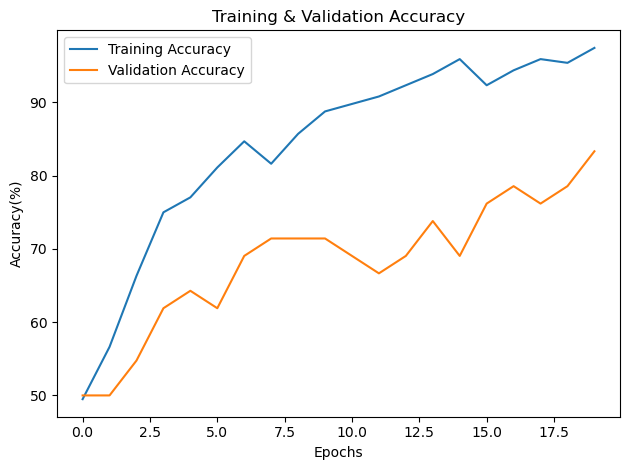

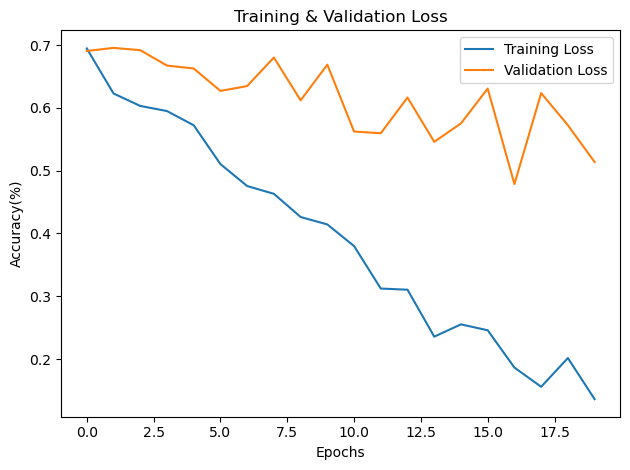

ModelClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_drop): Dropout2d(p=0.5, inplace=False)
  (dense): Linear(in_features=128, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=2, bias=True)
)

In [61]:
# Training Stage

train(model,num_of_epochs)

In [64]:
# Testing Stage

test_model(model,test_loader)


Testing model...
--------------------------------------------------

Class-wise Performance:
--------------------------------------------------
Pen            : 80.95% (17/21)
Pencil         : 90.48% (19/21)
--------------------------------------------------

Overall Accuracy: 85.71% (36/42)
--------------------------------------------------


85.71428571428571

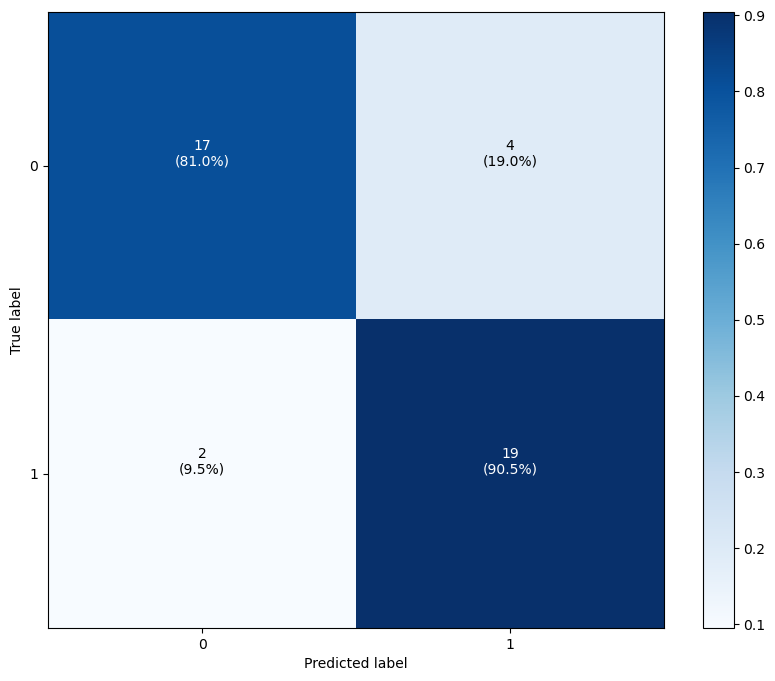

tensor([[17.,  4.],
        [ 2., 19.]])

In [65]:
# Confusion Matrix

create_confusion_matrix_manual(model,test_loader=test_loader,class_names=class_name,device=device)

Using device: cpu


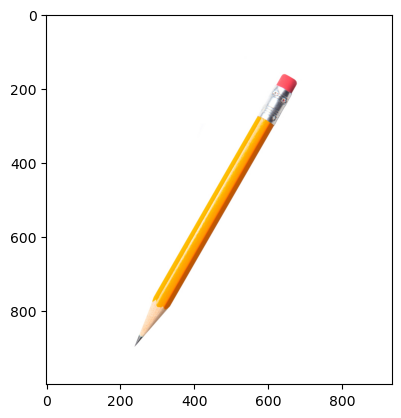


Prediction Results:
Most likely: Pencil (92.62% confidence)

All class probabilities:
Pen: 7.4%
Pencil: 92.6%


In [66]:
# Prediction Stage: Pencil 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/pencil_280523090.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


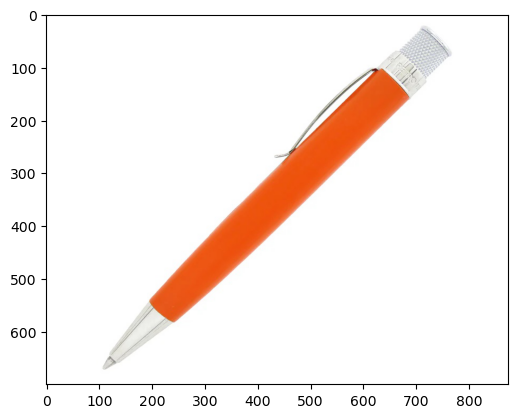


Prediction Results:
Most likely: Pencil (91.52% confidence)

All class probabilities:
Pen: 8.5%
Pencil: 91.5%


In [67]:
# Prediction Stage: Pen 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Documents/VRR-2452_seasonalTouchFall-autmnOrange_RB-02_875x700.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


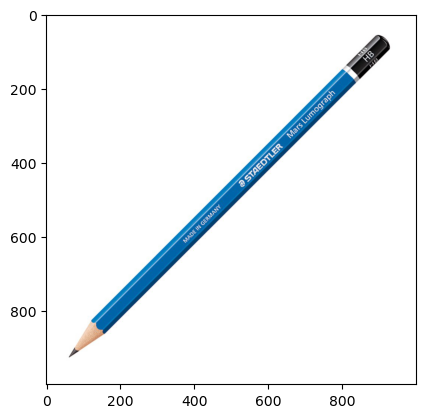


Prediction Results:
Most likely: Pencil (87.84% confidence)

All class probabilities:
Pen: 12.2%
Pencil: 87.8%


In [68]:
# Prediction Stage: Pencil 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/51TkKa5QdgL.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


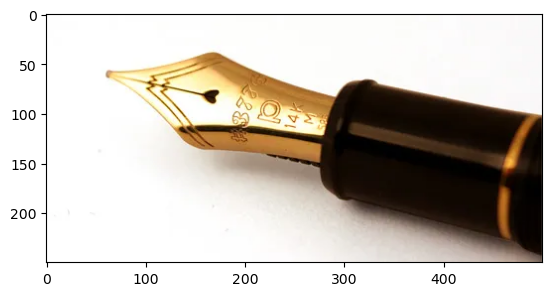


Prediction Results:
Most likely: Pen (94.89% confidence)

All class probabilities:
Pen: 94.9%
Pencil: 5.1%


In [71]:
# Prediction Stage: Pen
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/IMG_6997.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


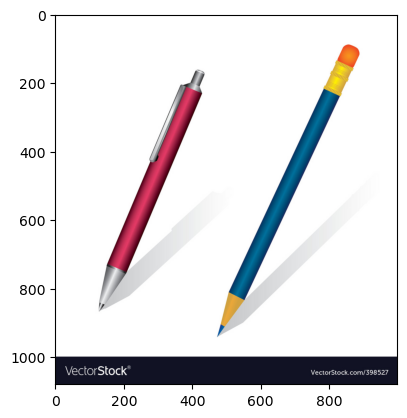


Prediction Results:
Most likely: Pencil (58.34% confidence)

All class probabilities:
Pen: 41.7%
Pencil: 58.3%


In [73]:
# Prediction Stage: Pencil & Pen (1)
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Example_1.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


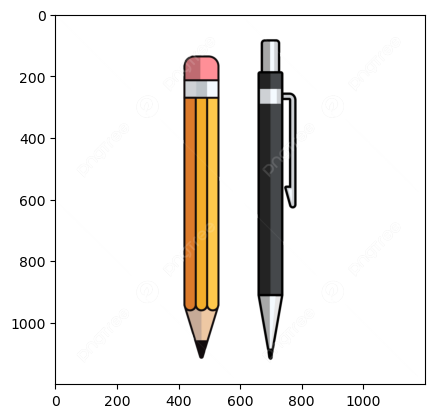


Prediction Results:
Most likely: Pencil (54.03% confidence)

All class probabilities:
Pen: 46.0%
Pencil: 54.0%


In [74]:
# Prediction Stage: Pencil & Pen (2)
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Example_2.png',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


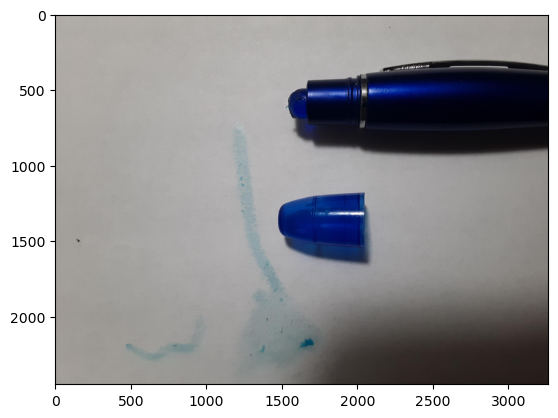


Prediction Results:
Most likely: Pen (99.67% confidence)

All class probabilities:
Pen: 99.7%
Pencil: 0.3%


In [76]:
# Prediction Stage: Pen 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/ue2ilgr1xau21.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


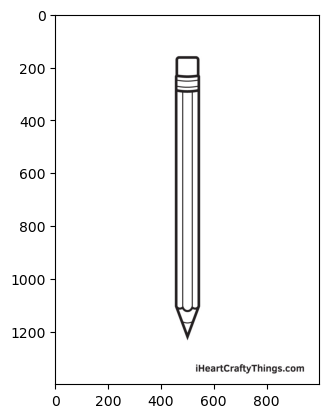


Prediction Results:
Most likely: Pencil (85.39% confidence)

All class probabilities:
Pen: 14.6%
Pencil: 85.4%


In [77]:
# Prediction Stage: Pencil 

example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/Pencil-DRAWING-–-STEP-9.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

Using device: cpu


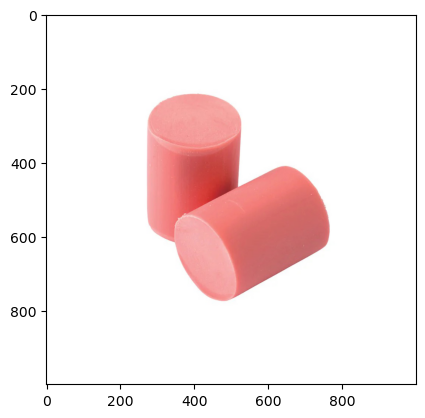


Prediction Results:
Most likely: Pencil (70.60% confidence)

All class probabilities:
Pen: 29.4%
Pencil: 70.6%


In [78]:
# Prediction Stage: Pencil 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Documents/Ohto_2_Eraser_Refill.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


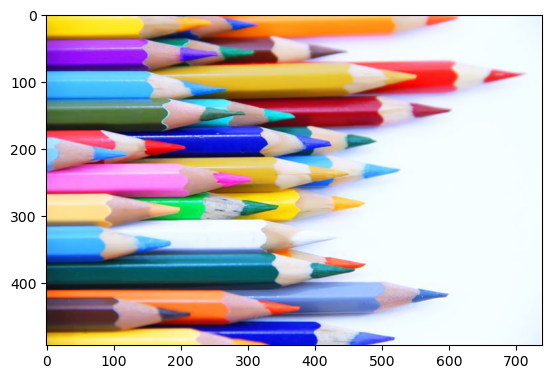


Prediction Results:
Most likely: Pen (90.43% confidence)

All class probabilities:
Pen: 90.4%
Pencil: 9.6%


In [79]:
# Prediction Stage: Pencil 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Downloads/picture-of-color-pencil-coloring.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


Using device: cpu


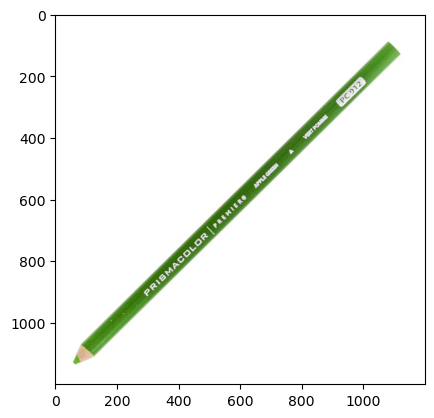


Prediction Results:
Most likely: Pencil (90.50% confidence)

All class probabilities:
Pen: 9.5%
Pencil: 90.5%


In [80]:
# Prediction Stage: Pencil 
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/Users/tony/Documents/prismacolor-premier-colored-pencil-apple-green-912-883395_1200x1200_crop_center.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


In [ ]:
# Example usage
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_custom_image(
            model=model,
            image_path='/content/4539621__64029.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")


In [ ]:
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_with_debug(
            model=model,
            image_path='/content/Ohto_2_Eraser_Refill.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")

In [ ]:
example_classes = test_loader.dataset.classes

pred_class, confidence, all_probs = predict_with_debug(
            model=model,
            image_path='/content/610qJ+apPML._AC_UF1000,1000_QL80_.jpg',
            class_names=example_classes
        )

print(f"\nPrediction Results:")
print(f"Most likely: {pred_class} ({confidence*100:.2f}% confidence)")
print("\nAll class probabilities:")
for cls, prob in all_probs.items():
    print(f"{cls}: {prob}")